# Ensemble Strategy: Specialist Models with Advanced Techniques

**Improvements over original notebook:**
1. **TTA Multi-view Testing** - 6 views per video (3 spatial × 2 temporal)
2. **Class-Balanced Sampling** - WeightedRandomSampler (no undersampling)
3. **Adaptive Ensemble** - Confidence-based specialist gating

---
- **Global Model:** 51 classes (pre-trained, loaded from checkpoint)
- **Specialist A (Motion):** jump, run, climb_stairs + Others (4 classes)
- **Specialist B (Face):** smile, talk, laugh + Others (4 classes)

## 1. Configuration

**[MODIFIED]** Added TTA and Adaptive Ensemble configuration

In [12]:
# =================== CONFIGURATION ===================
# Specialist Targets
SPECIALIST_A_TARGETS = ['jump', 'run', 'climb_stairs']
SPECIALIST_B_TARGETS = ['smile', 'talk', 'laugh']

# Model Config
NUM_FRAMES = 8
IMG_SIZE = 224
RESIZE_SIZE = 256

# Training Config
BATCH_SIZE = 8
ACCUM_STEPS = 4
EPOCHS_P1 = 10
EPOCHS_P2 = 5
LR_P1 = 5e-5
LR_P2 = 1e-6
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.1
MIXUP_ALPHA = 0.8
LABEL_SMOOTHING_EPS = 0.1

# [NEW] TTA Configuration
USE_TTA = True  # Flag to enable/disable Test Time Augmentation

# [NEW] Adaptive Ensemble Configuration
CONFIDENCE_THRESHOLD = 0.7  # Only use specialist if global confidence < threshold
SENSITIVE_CLASSES = ['jump', 'run', 'climb_stairs', 'smile', 'talk', 'laugh']

# Ensemble Fusion Weight
FUSION_WEIGHT = 1.0

# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'
TEST_LABELS_URL = '1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_'

# Global Model Checkpoint (FILL THIS PATH)
GLOBAL_MODEL_CKPT = "/kaggle/input/vit-video-classification/pytorch/default/1/kaggle/working/videomae_final_best"  # <-- PUT YOUR GLOBAL MODEL PATH HERE

print('Configuration loaded.')
print(f'  TTA: {USE_TTA}')
print(f'  Confidence Threshold: {CONFIDENCE_THRESHOLD}')
print(f'  Sensitive Classes: {SENSITIVE_CLASSES}')

Configuration loaded.
  TTA: True
  Confidence Threshold: 0.7
  Sensitive Classes: ['jump', 'run', 'climb_stairs', 'smile', 'talk', 'laugh']


## 2. Imports & Setup

In [13]:
import os, gc, random, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from transformers import VideoMAEForVideoClassification
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# Multi-GPU Setup
N_GPUS = torch.cuda.device_count()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}, Available GPUs: {N_GPUS}')

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Device: cuda, Available GPUs: 2


## 3. Dataset Classes

**[MODIFIED]** Added TTATestDataset with 6-view generation

In [14]:
class VideoDataset(Dataset):
    """Base dataset with consistent spatial augmentation."""
    def __init__(self, root, num_frames=16, consistent_aug=True):
        self.root = Path(root)
        self.num_frames = num_frames
        self.consistent_aug = consistent_aug
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            for vid in (self.root / cls).iterdir():
                if vid.is_dir():
                    self.samples.append((vid, self.class_to_idx[cls]))
        print(f'Loaded {len(self.samples)} videos, {len(self.classes)} classes')
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        vid_dir, label = self.samples[idx]
        files = sorted(vid_dir.glob('*.jpg'))
        indices = torch.linspace(0, len(files)-1, self.num_frames).long()
        frames = [Image.open(files[i]).convert('RGB') for i in indices]
        frames = [TF.resize(img, RESIZE_SIZE) for img in frames]
        
        if self.consistent_aug:
            i, j, h, w = T.RandomResizedCrop.get_params(frames[0], (0.8, 1.0), (0.75, 1.33))
            do_flip = random.random() > 0.5
            processed = []
            for img in frames:
                img = TF.resized_crop(img, i, j, h, w, (IMG_SIZE, IMG_SIZE))
                if do_flip: img = TF.hflip(img)
                processed.append(TF.normalize(TF.to_tensor(img), MEAN, STD))
        else:
            processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), label


# [NEW] TTA Test Dataset with Multi-view Testing
class TTATestDataset(Dataset):
    """
    Test dataset with TTA support: 3 spatial crops × 2 temporal crops = 6 views.
    
    Spatial crops: Left, Center, Right
    Temporal crops: Start segment, End segment of video
    """
    def __init__(self, root, num_frames=16, use_tta=True):
        self.root = Path(root)
        self.num_frames = num_frames
        self.use_tta = use_tta
        self.samples = [(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()]
        self.samples.sort(key=lambda x: x[1])
        print(f'TTATestDataset: {len(self.samples)} videos, TTA={use_tta}')
    
    def _get_spatial_crop(self, img, crop_type):
        """Apply spatial crop: left, center, or right."""
        w, h = img.size
        crop_size = min(w, h, IMG_SIZE)
        
        if crop_type == 'left':
            left = 0
        elif crop_type == 'right':
            left = w - crop_size
        else:  # center
            left = (w - crop_size) // 2
        
        top = (h - crop_size) // 2
        return TF.resized_crop(img, top, left, crop_size, crop_size, (IMG_SIZE, IMG_SIZE))
    
    def _load_frames_temporal(self, vid_dir, temporal_position='full'):
        """Load frames with temporal crop (start, end, or full video)."""
        files = sorted(vid_dir.glob('*.jpg'))
        total_frames = len(files)
        
        if temporal_position == 'start':
            end_idx = min(total_frames - 1, int(total_frames * 0.7))
            indices = torch.linspace(0, end_idx, self.num_frames).long()
        elif temporal_position == 'end':
            start_idx = max(0, int(total_frames * 0.3))
            indices = torch.linspace(start_idx, total_frames - 1, self.num_frames).long()
        else:  # full
            indices = torch.linspace(0, total_frames - 1, self.num_frames).long()
        
        return [Image.open(files[i]).convert('RGB') for i in indices]
    
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        vid_dir, vid_id = self.samples[idx]
        
        if not self.use_tta:
            # Standard single center crop (original behavior)
            files = sorted(vid_dir.glob('*.jpg'))
            indices = torch.linspace(0, len(files)-1, self.num_frames).long()
            frames = []
            for i in indices:
                img = Image.open(files[i]).convert('RGB')
                img = TF.resize(img, RESIZE_SIZE)
                img = TF.center_crop(img, IMG_SIZE)
                frames.append(TF.normalize(TF.to_tensor(img), MEAN, STD))
            return torch.stack(frames), vid_id
        
        # TTA: Generate 6 views (3 spatial × 2 temporal)
        views = []
        spatial_crops = ['left', 'center', 'right']
        temporal_positions = ['start', 'end']
        
        for temp_pos in temporal_positions:
            frames_raw = self._load_frames_temporal(vid_dir, temp_pos)
            frames_raw = [TF.resize(img, RESIZE_SIZE) for img in frames_raw]
            
            for spatial_crop in spatial_crops:
                frames = []
                for img in frames_raw:
                    cropped = self._get_spatial_crop(img, spatial_crop)
                    frames.append(TF.normalize(TF.to_tensor(cropped), MEAN, STD))
                views.append(torch.stack(frames))
        
        # Return shape: (6, num_frames, C, H, W)
        return torch.stack(views), vid_id

print('Dataset classes defined.')

Dataset classes defined.


## 4. Specialist Dataset with Class-Balanced Sampling

**[MODIFIED]** Replaced undersampling with WeightedRandomSampler - keeps all data

In [15]:
class SpecialistDatasetBalanced(Dataset):
    """
    Wraps VideoDataset for specialist training with Class-Balanced Sampling.
    
    - Target classes -> 0..N-1
    - All other classes -> N (Others)
    - NO undersampling: all data is preserved
    - Uses WeightedRandomSampler for balanced training
    """
    def __init__(self, base_dataset, target_classes):
        self.base_dataset = base_dataset
        self.target_classes = target_classes
        self.num_targets = len(target_classes)
        self.target_to_new_idx = {cls: i for i, cls in enumerate(target_classes)}
        self.others_idx = self.num_targets
        
        self.samples = []
        self.targets = []  # Required for WeightedRandomSampler
        
        for orig_idx, (vid_path, orig_label) in enumerate(base_dataset.samples):
            orig_class = base_dataset.classes[orig_label]
            if orig_class in self.target_to_new_idx:
                new_label = self.target_to_new_idx[orig_class]
            else:
                new_label = self.others_idx
            
            self.samples.append((orig_idx, new_label))
            self.targets.append(new_label)
        
        self.targets = torch.tensor(self.targets)
        self.classes = target_classes + ['Others']
        
        # Print class distribution
        counts = Counter([s[1] for s in self.samples])
        print(f'  SpecialistDatasetBalanced: {len(self.samples)} samples (ALL data preserved)')
        for i, cls in enumerate(self.classes):
            print(f'    {cls}: {counts.get(i, 0)}')
    
    def get_sampler(self):
        """Create WeightedRandomSampler for balanced training."""
        class_counts = torch.bincount(self.targets)
        weights = 1.0 / class_counts.float()
        sample_weights = weights[self.targets]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        print(f'  Created WeightedRandomSampler with weights: {weights.tolist()}')
        return sampler
    
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        orig_idx, new_label = self.samples[idx]
        video, _ = self.base_dataset[orig_idx]
        return video, new_label

print('SpecialistDatasetBalanced defined.')

SpecialistDatasetBalanced defined.


## 5. Model Factory (Multi-GPU with DataParallel)

In [16]:
def create_model(num_classes, num_frames=16, use_dp=True):
    """Create VideoMAE model with optional DataParallel."""
    model = VideoMAEForVideoClassification.from_pretrained(
        'MCG-NJU/videomae-base-finetuned-kinetics',
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        num_frames=num_frames
    )
    if use_dp and N_GPUS > 1:
        model = nn.DataParallel(model)
        print(f'Created VideoMAE with DataParallel ({N_GPUS} GPUs)')
    else:
        print(f'Created VideoMAE on single GPU')
    return model.to(DEVICE)

print('Model factory defined.')

Model factory defined.


## 6. Mixup Augmentation

In [17]:
class MixupCollate:
    def __init__(self, num_classes, alpha=0.8):
        self.num_classes = num_classes
        self.alpha = alpha
    
    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        bs = inputs.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(bs)
        inputs = lam * inputs + (1 - lam) * inputs[index]
        targets_oh = F.one_hot(targets, self.num_classes).float()
        targets = lam * targets_oh + (1 - lam) * targets_oh[index]
        return inputs, targets

print('Mixup defined.')

Mixup defined.


## 7. Training Functions

In [18]:
def train_epoch(model, loader, optimizer, scheduler, scaler, use_mixup=False, label_smoothing=0.0):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc='Train', leave=False)
    optimizer.zero_grad()
    
    for step, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            out = model(inputs)
            logits = out.logits if hasattr(out, 'logits') else out
            
            if use_mixup:
                loss = -torch.sum(targets * F.log_softmax(logits, dim=1), dim=1).mean()
                true_labels = targets.argmax(1)
            else:
                loss = F.cross_entropy(logits, targets, label_smoothing=label_smoothing)
                true_labels = targets
        
        correct += (logits.argmax(1) == true_labels).sum().item()
        total += inputs.size(0)
        
        scaler.scale(loss / ACCUM_STEPS).backward()
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler: scheduler.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{total_loss/(step+1):.4f}', 'acc': f'{correct/total:.4f}'})
    
    return total_loss / (step+1), correct / total

print('Training functions defined.')

Training functions defined.


## 8. Specialist Training Pipeline

**[MODIFIED]** Uses WeightedRandomSampler instead of undersampling

In [19]:
def train_specialist(name, target_classes, base_ds):
    print(f'\n{"="*60}')
    print(f'TRAINING SPECIALIST: {name.upper()}')
    print(f'Targets: {target_classes}')
    print(f'{"="*60}')
    
    # [MODIFIED] Use balanced dataset with WeightedRandomSampler
    spec_ds = SpecialistDatasetBalanced(base_ds, target_classes)
    sampler = spec_ds.get_sampler()
    num_classes = len(spec_ds.classes)
    model = create_model(num_classes, NUM_FRAMES, use_dp=(N_GPUS > 1))
    
    # Phase 1 DataLoader with Mixup + WeightedRandomSampler
    mixup = MixupCollate(num_classes, MIXUP_ALPHA)
    # [MODIFIED] shuffle=False with sampler
    loader_p1 = DataLoader(spec_ds, BATCH_SIZE * N_GPUS, shuffle=False, 
                           sampler=sampler, num_workers=2, 
                           collate_fn=mixup, drop_last=True)
    loader_p2 = DataLoader(spec_ds, BATCH_SIZE * N_GPUS, shuffle=False,
                           sampler=sampler, num_workers=2, drop_last=True)
    
    history = []
    best_acc = 0.0
    scaler = torch.amp.GradScaler()
    
    # Phase 1
    print(f'\n--- Phase 1: Mixup ({EPOCHS_P1} epochs, LR={LR_P1}) ---')
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P1, weight_decay=WEIGHT_DECAY)
    total_steps = len(loader_p1) * EPOCHS_P1 // ACCUM_STEPS
    scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)
    
    for ep in range(1, EPOCHS_P1 + 1):
        loss, acc = train_epoch(model, loader_p1, optimizer, scheduler, scaler, use_mixup=True)
        history.append({'epoch': ep, 'phase': 1, 'loss': loss, 'acc': acc})
        status = ''
        if acc > best_acc:
            best_acc = acc
            state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state, f'specialist_{name}_best_p1.pt')
            status = '>>> BEST'
        print(f'Ep {ep}/{EPOCHS_P1}: L={loss:.4f} Acc={acc:.4f} {status}')
        gc.collect(); torch.cuda.empty_cache()
    
    # Phase 2
    print(f'\n--- Phase 2: Label Smoothing ({EPOCHS_P2} epochs, LR={LR_P2}) ---')
    state = torch.load(f'specialist_{name}_best_p1.pt')
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(state)
    else: model.load_state_dict(state)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P2, weight_decay=WEIGHT_DECAY)
    total_steps = len(loader_p2) * EPOCHS_P2 // ACCUM_STEPS
    scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)
    scaler = torch.amp.GradScaler()
    
    for ep in range(1, EPOCHS_P2 + 1):
        loss, acc = train_epoch(model, loader_p2, optimizer, scheduler, scaler, label_smoothing=LABEL_SMOOTHING_EPS)
        history.append({'epoch': EPOCHS_P1 + ep, 'phase': 2, 'loss': loss, 'acc': acc})
        status = ''
        if acc > best_acc:
            best_acc = acc
            state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state, f'specialist_{name}_best.pt')
            status = '>>> BEST'
        print(f'P2 Ep {ep}/{EPOCHS_P2}: L={loss:.4f} Acc={acc:.4f} {status}')
        gc.collect(); torch.cuda.empty_cache()
    
    # Load best
    best_path = f'specialist_{name}_best.pt' if os.path.exists(f'specialist_{name}_best.pt') else f'specialist_{name}_best_p1.pt'
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(torch.load(best_path))
    else: model.load_state_dict(torch.load(best_path))
    
    print(f'\n✓ Specialist {name} complete. Best Acc: {best_acc:.4f}')
    return model, history, spec_ds.classes

print('Training pipeline defined.')

Training pipeline defined.


## 9. Load Base Dataset & Train Specialists

In [20]:
print('Loading base dataset...')
base_ds = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, consistent_aug=True)
MAIN_CLASSES = base_ds.classes
print(f'Classes: {len(MAIN_CLASSES)}')

Loading base dataset...
Loaded 6254 videos, 51 classes
Classes: 51


In [21]:
# Train Specialist A (Motion)
spec_A_model, hist_A, classes_A = train_specialist('motion', SPECIALIST_A_TARGETS, base_ds)


TRAINING SPECIALIST: MOTION
Targets: ['jump', 'run', 'climb_stairs']
  SpecialistDatasetBalanced: 6254 samples (ALL data preserved)
    jump: 141
    run: 222
    climb_stairs: 102
    Others: 5789
  Created WeightedRandomSampler with weights: [0.007092198356986046, 0.0045045046135783195, 0.009803921915590763, 0.00017274140554945916]


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created VideoMAE with DataParallel (2 GPUs)

--- Phase 1: Mixup (10 epochs, LR=5e-05) ---


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 1/10: L=0.9885 Acc=0.6615 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 2/10: L=0.5765 Acc=0.8821 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 3/10: L=0.5060 Acc=0.9079 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 4/10: L=0.4962 Acc=0.9037 


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 5/10: L=0.4576 Acc=0.9232 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 6/10: L=0.4441 Acc=0.9261 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 7/10: L=0.4151 Acc=0.9393 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 9/10: L=0.4015 Acc=0.9500 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 10/10: L=0.4022 Acc=0.9455 

--- Phase 2: Label Smoothing (5 epochs, LR=1e-06) ---


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 1/5: L=0.3893 Acc=0.9990 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 2/5: L=0.3593 Acc=0.9998 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 3/5: L=0.3567 Acc=0.9992 


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 4/5: L=0.3560 Acc=0.9995 


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 5/5: L=0.3557 Acc=0.9992 

✓ Specialist motion complete. Best Acc: 0.9998


In [23]:
# Train Specialist B (Face)
spec_B_model, hist_B, classes_B = train_specialist('face', SPECIALIST_B_TARGETS, base_ds)


TRAINING SPECIALIST: FACE
Targets: ['smile', 'talk', 'laugh']
  SpecialistDatasetBalanced: 6254 samples (ALL data preserved)
    smile: 90
    talk: 110
    laugh: 118
    Others: 5936
  Created WeightedRandomSampler with weights: [0.011111111380159855, 0.00909090880304575, 0.008474576286971569, 0.0001684636081336066]


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created VideoMAE with DataParallel (2 GPUs)

--- Phase 1: Mixup (10 epochs, LR=5e-05) ---


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 1/10: L=0.8635 Acc=0.7311 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 2/10: L=0.4753 Acc=0.9032 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 3/10: L=0.4445 Acc=0.9192 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 4/10: L=0.4187 Acc=0.9298 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 5/10: L=0.3839 Acc=0.9341 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 6/10: L=0.3737 Acc=0.9434 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 7/10: L=0.3683 Acc=0.9506 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 8/10: L=0.3658 Acc=0.9519 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 9/10: L=0.3610 Acc=0.9587 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

Ep 10/10: L=0.3657 Acc=0.9527 

--- Phase 2: Label Smoothing (5 epochs, LR=1e-06) ---


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 1/5: L=0.4060 Acc=0.9997 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 2/5: L=0.3580 Acc=1.0000 >>> BEST


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 3/5: L=0.3541 Acc=0.9995 


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 4/5: L=0.3528 Acc=0.9998 


Train:   0%|          | 0/390 [00:00<?, ?it/s]

P2 Ep 5/5: L=0.3523 Acc=1.0000 

✓ Specialist face complete. Best Acc: 1.0000


## 10. Learning Curves

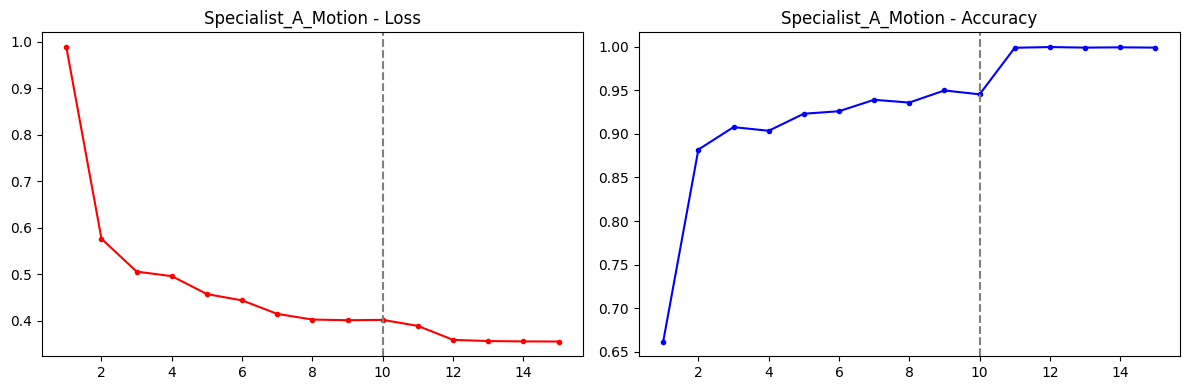

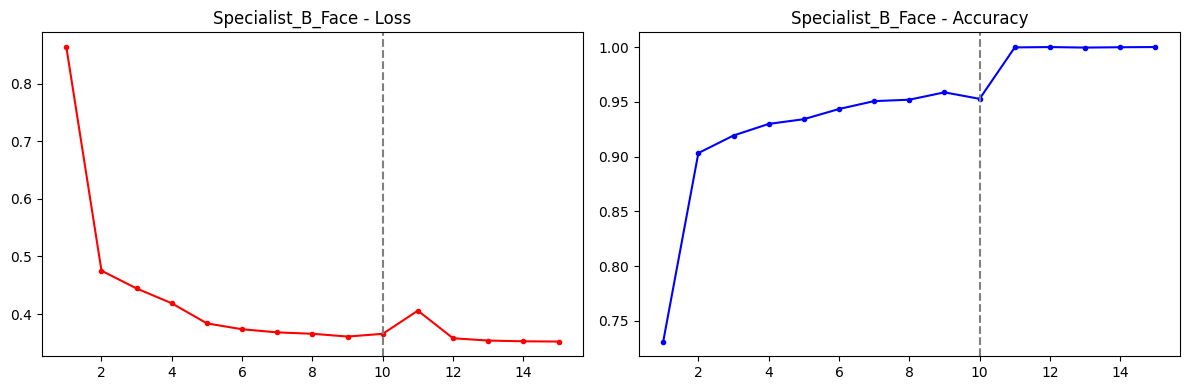

In [24]:
def plot_curves(hist, title):
    df = pd.DataFrame(hist)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(df['epoch'], df['loss'], 'r-o', ms=3)
    ax[0].axvline(x=EPOCHS_P1, color='gray', ls='--')
    ax[0].set_title(f'{title} - Loss')
    ax[1].plot(df['epoch'], df['acc'], 'b-o', ms=3)
    ax[1].axvline(x=EPOCHS_P1, color='gray', ls='--')
    ax[1].set_title(f'{title} - Accuracy')
    plt.tight_layout(); plt.savefig(f'curves_{title}.png', dpi=150); plt.show()

plot_curves(hist_A, 'Specialist_A_Motion')
plot_curves(hist_B, 'Specialist_B_Face')

## 11. Load Global Model

In [27]:
print("Loading Global Model (HF)...")
global_model = VideoMAEForVideoClassification.from_pretrained(
    GLOBAL_MODEL_CKPT
).to(DEVICE)

global_model.eval()

print("Global Model loaded.")


Loading Global Model (HF)...
Global Model loaded.


## 12. Adaptive Ensemble Inference

**[MODIFIED]** Replaced fixed-weight fusion with Confidence-based Gating

In [28]:
def get_indices(main_classes, targets):
    return [main_classes.index(c) for c in targets if c in main_classes]

@torch.no_grad()
def adaptive_ensemble_predict(global_m, spec_A, spec_B, video, debug=False):
    """
    Adaptive Ensemble prediction with confidence-based gating.
    
    Logic:
    1. Get global model predictions
    2. For each sample, check:
       - If confidence < THRESHOLD OR pred_class in sensitive_classes
       - Then apply specialist fusion
       - Else use global only
    """
    idx_A = get_indices(MAIN_CLASSES, SPECIALIST_A_TARGETS)
    idx_B = get_indices(MAIN_CLASSES, SPECIALIST_B_TARGETS)
    sensitive_idx = set(get_indices(MAIN_CLASSES, SENSITIVE_CLASSES))
    
    # Global logits
    out_g = global_m(video)
    logits_global = (out_g.logits if hasattr(out_g, 'logits') else out_g).clone()
    
    # Calculate confidence
    probs = F.softmax(logits_global, dim=1)
    confidence, pred_class = probs.max(dim=1)
    
    # Initialize final logits with global
    final_logits = logits_global.clone()
    
    # Determine which samples need specialist
    needs_specialist_conf = confidence < CONFIDENCE_THRESHOLD
    needs_specialist_sens = torch.tensor(
        [p.item() in sensitive_idx for p in pred_class], 
        device=video.device, dtype=torch.bool
    )
    needs_specialist = needs_specialist_conf | needs_specialist_sens
    
    specialist_used_count = needs_specialist.sum().item()
    
    if needs_specialist.any():
        # Get specialist logits
        out_a = spec_A(video)
        logits_a = out_a.logits if hasattr(out_a, 'logits') else out_a
        
        out_b = spec_B(video)
        logits_b = out_b.logits if hasattr(out_b, 'logits') else out_b
        
        # Apply fusion only for samples that need it
        for batch_idx in range(video.size(0)):
            if needs_specialist[batch_idx]:
                # Specialist A contribution
                for i, main_idx in enumerate(idx_A):
                    final_logits[batch_idx, main_idx] += FUSION_WEIGHT * logits_a[batch_idx, i]
                
                # Specialist B contribution
                for i, main_idx in enumerate(idx_B):
                    final_logits[batch_idx, main_idx] += FUSION_WEIGHT * logits_b[batch_idx, i]
                
                if debug:
                    reason = 'low_conf' if needs_specialist_conf[batch_idx] else 'sensitive'
                    print(f'  Sample {batch_idx}: conf={confidence[batch_idx]:.3f}, '
                          f'pred={MAIN_CLASSES[pred_class[batch_idx]]}, '
                          f'reason={reason}, using SPECIALIST')
            elif debug:
                print(f'  Sample {batch_idx}: conf={confidence[batch_idx]:.3f}, '
                      f'pred={MAIN_CLASSES[pred_class[batch_idx]]}, '
                      f'GLOBAL only')
    
    return final_logits, specialist_used_count

print('Adaptive Ensemble logic defined.')

Adaptive Ensemble logic defined.


## 13. TTA Inference Helper

**[NEW]** Multi-view averaging for TTA

In [42]:
@torch.no_grad()
def tta_model_forward(model, video_views):
    """
    Handles Test Time Augmentation (TTA) forward pass.
    Input shape: (Batch, Views, Frames, Channels, Height, Width)
    """
    # Check if input is 6D (TTA mode with views)
    if video_views.ndim == 6:
        b, v, t, c, h, w = video_views.shape
        
        # 1. Fuse Batch and Views dimensions
        # New shape: (Batch * Views, Frames, Channels, Height, Width)
        videos_reshaped = video_views.view(b * v, t, c, h, w)
        
        # 2. Forward pass
        # The model sees a larger batch size now
        outputs = model(videos_reshaped)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        # 3. Reshape back to separate Views
        # Shape: (Batch, Views, Num_Classes)
        logits = logits.view(b, v, -1)
        
        # 4. Average predictions across the views
        # Final Shape: (Batch, Num_Classes)
        return logits.mean(dim=1)

    # Fallback for standard 5D input (Non-TTA)
    else:
        outputs = model(video_views)
        return outputs.logits if hasattr(outputs, 'logits') else outputs


@torch.no_grad()
def tta_ensemble_predict(global_m, spec_A, spec_B, video_views, debug=False):
    """
    TTA + Adaptive Ensemble prediction.
    Averages logits across views, then applies confidence-based gating.
    """
    idx_A = get_indices(MAIN_CLASSES, SPECIALIST_A_TARGETS)
    idx_B = get_indices(MAIN_CLASSES, SPECIALIST_B_TARGETS)
    sensitive_idx = set(get_indices(MAIN_CLASSES, SENSITIVE_CLASSES))
    
    # Get averaged global logits via TTA
    logits_global = tta_model_forward(global_m, video_views)
    
    # Calculate confidence
    probs = F.softmax(logits_global, dim=1)
    confidence, pred_class = probs.max(dim=1)
    
    # Initialize final logits
    final_logits = logits_global.clone()
    
    # Determine which samples need specialist
    needs_specialist_conf = confidence < CONFIDENCE_THRESHOLD
    needs_specialist_sens = torch.tensor(
        [p.item() in sensitive_idx for p in pred_class],
        device=logits_global.device, dtype=torch.bool
    )
    needs_specialist = needs_specialist_conf | needs_specialist_sens
    
    specialist_used_count = needs_specialist.sum().item()
    
    if needs_specialist.any():
        # Get averaged specialist logits via TTA
        logits_a = tta_model_forward(spec_A, video_views)
        logits_b = tta_model_forward(spec_B, video_views)
        
        # Apply fusion
        for batch_idx in range(logits_global.size(0)):
            if needs_specialist[batch_idx]:
                for i, main_idx in enumerate(idx_A):
                    final_logits[batch_idx, main_idx] += FUSION_WEIGHT * logits_a[batch_idx, i]
                for i, main_idx in enumerate(idx_B):
                    final_logits[batch_idx, main_idx] += FUSION_WEIGHT * logits_b[batch_idx, i]
    
    return final_logits, specialist_used_count

print('TTA inference helpers defined.')

TTA inference helpers defined.


## 14. Run Evaluation

**[MODIFIED]** Uses TTA dataset and adaptive ensemble

In [43]:
# Load test labels
import gdown
gdown.download(f'https://drive.google.com/uc?id={TEST_LABELS_URL}', 'test_labels.csv', quiet=True)
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))
print(f'Loaded {len(gt_dict)} test labels.')

Loaded 510 test labels.


In [44]:
# [MODIFIED] Use TTA Test Dataset
test_ds = TTATestDataset(PATH_DATA_TEST, NUM_FRAMES, use_tta=USE_TTA)
test_loader = DataLoader(test_ds, batch_size=1 if USE_TTA else BATCH_SIZE, 
                         shuffle=False, num_workers=2)
print(f'Test: {len(test_ds)} samples, TTA={USE_TTA}')

TTATestDataset: 510 videos, TTA=True
Test: 510 samples, TTA=True


In [45]:
global_model.eval()
spec_A_model.eval()
spec_B_model.eval()

preds_global, preds_ensemble, all_true = [], [], []
total_specialist_used = 0

with torch.no_grad():
    for videos, vids in tqdm(test_loader, desc='Eval'):
        videos = videos.to(DEVICE)
        
        if USE_TTA:
            # TTA mode - videos shape: (batch, 6, frames, C, H, W)
            logits_g = tta_model_forward(global_model, videos)
            preds_g = logits_g.argmax(1).cpu().tolist()
            
            logits_e, specialist_count = tta_ensemble_predict(
                global_model, spec_A_model, spec_B_model, videos
            )
            preds_e = logits_e.argmax(1).cpu().tolist()
            total_specialist_used += specialist_count
        else:
            # Non-TTA mode
            out_g = global_model(videos)
            logits_g = out_g.logits if hasattr(out_g, 'logits') else out_g
            preds_g = logits_g.argmax(1).cpu().tolist()
            
            logits_e, specialist_count = adaptive_ensemble_predict(
                global_model, spec_A_model, spec_B_model, videos
            )
            preds_e = logits_e.argmax(1).cpu().tolist()
            total_specialist_used += specialist_count
        
        for vid, pg, pe in zip(vids.tolist(), preds_g, preds_e):
            all_true.append(gt_dict[str(vid)])
            preds_global.append(MAIN_CLASSES[pg])
            preds_ensemble.append(MAIN_CLASSES[pe])

print(f'Evaluated {len(all_true)} samples.')
print(f'Specialist models used for {total_specialist_used}/{len(all_true)} samples '
      f'({100*total_specialist_used/len(all_true):.1f}%)')

Eval:   0%|          | 0/510 [00:00<?, ?it/s]

Evaluated 510 samples.
Specialist models used for 230/510 samples (45.1%)


## 15. Results & Metrics

In [46]:
acc_g = accuracy_score(all_true, preds_global)
acc_e = accuracy_score(all_true, preds_ensemble)

print('='*60)
print('ACCURACY COMPARISON')
print('='*60)
print(f'Global Model:  {acc_g*100:.2f}%')
print(f'Ensemble:      {acc_e*100:.2f}%')
print(f'Improvement:   {(acc_e-acc_g)*100:+.2f}%')

ACCURACY COMPARISON
Global Model:  82.35%
Ensemble:      82.35%
Improvement:   +0.00%


In [47]:
print('\nDETAILED METRICS (ENSEMBLE)')
print('='*60)
print(f'Accuracy:     {acc_e:.4f}')
print(f'Precision:    {precision_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'Recall:       {recall_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'F1 (Macro):   {f1_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'F1 (Weighted):{f1_score(all_true, preds_ensemble, average="weighted", zero_division=0):.4f}')


DETAILED METRICS (ENSEMBLE)
Accuracy:     0.8235
Precision:    0.8458
Recall:       0.8235
F1 (Macro):   0.8199
F1 (Weighted):0.8199


In [48]:
# Target class improvement
print('\nTARGET CLASS IMPROVEMENT')
print('='*60)
for cls in SPECIALIST_A_TARGETS + SPECIALIST_B_TARGETS:
    idx = [i for i, t in enumerate(all_true) if t == cls]
    if not idx: continue
    ag = accuracy_score([all_true[i] for i in idx], [preds_global[i] for i in idx])
    ae = accuracy_score([all_true[i] for i in idx], [preds_ensemble[i] for i in idx])
    print(f'{cls:15s}: Global={ag*100:5.1f}% -> Ensemble={ae*100:5.1f}% ({(ae-ag)*100:+.1f}%)')


TARGET CLASS IMPROVEMENT
jump           : Global= 40.0% -> Ensemble= 30.0% (-10.0%)
run            : Global= 40.0% -> Ensemble= 40.0% (+0.0%)
climb_stairs   : Global= 50.0% -> Ensemble= 50.0% (+0.0%)
smile          : Global= 80.0% -> Ensemble= 90.0% (+10.0%)
talk           : Global= 80.0% -> Ensemble= 90.0% (+10.0%)
laugh          : Global= 80.0% -> Ensemble= 80.0% (+0.0%)


## 16. Confusion Matrix

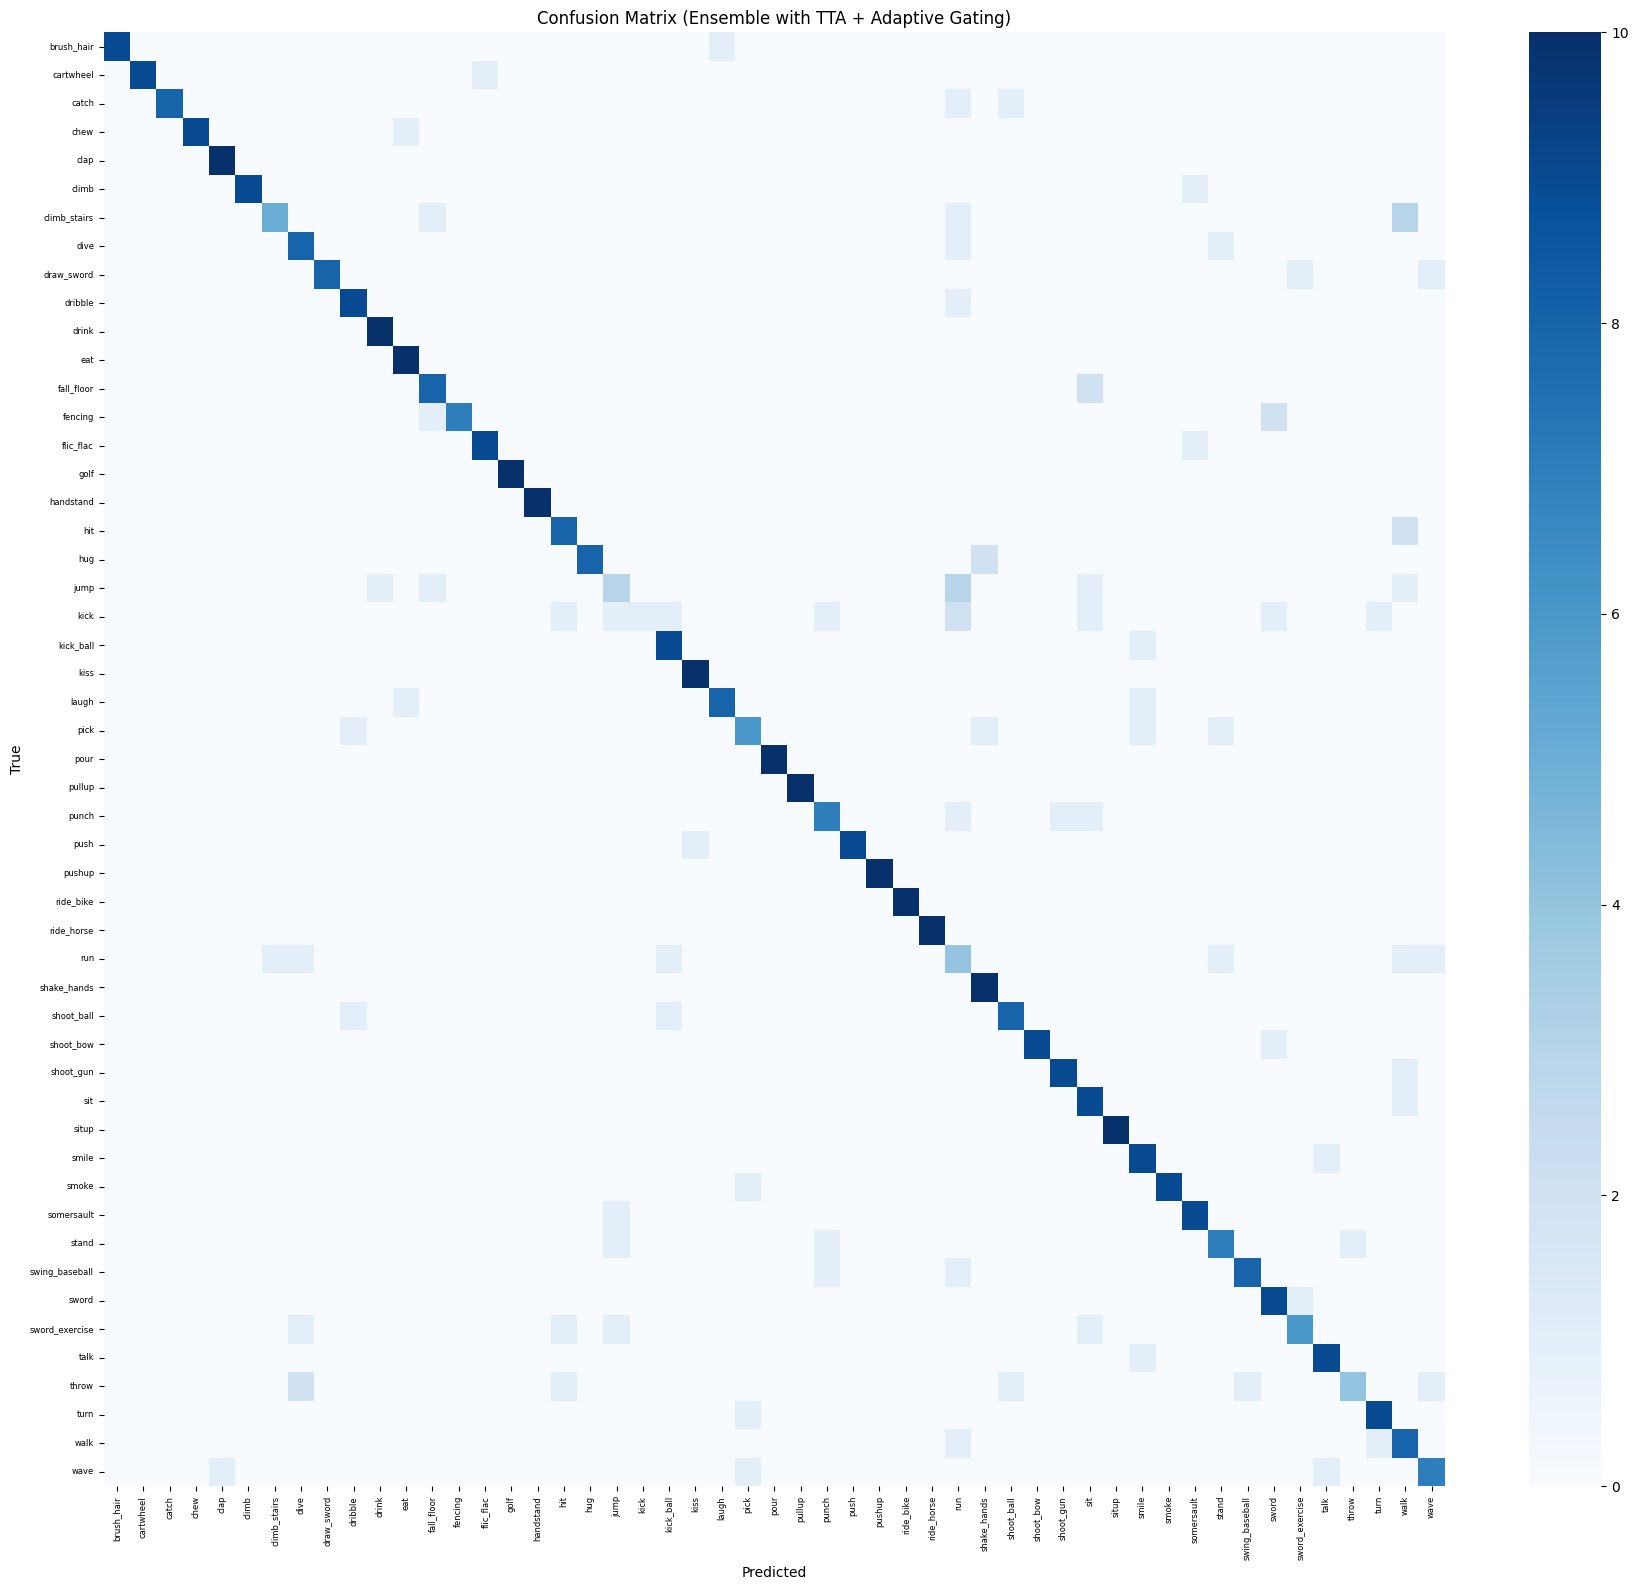

In [49]:
cm = confusion_matrix(all_true, preds_ensemble, labels=MAIN_CLASSES)
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=MAIN_CLASSES, yticklabels=MAIN_CLASSES)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Ensemble with TTA + Adaptive Gating)')
plt.xticks(rotation=90, fontsize=6); plt.yticks(fontsize=6)
plt.tight_layout(); plt.savefig('confusion_matrix_improved.png', dpi=150); plt.show()

## 17. Prediction Distribution

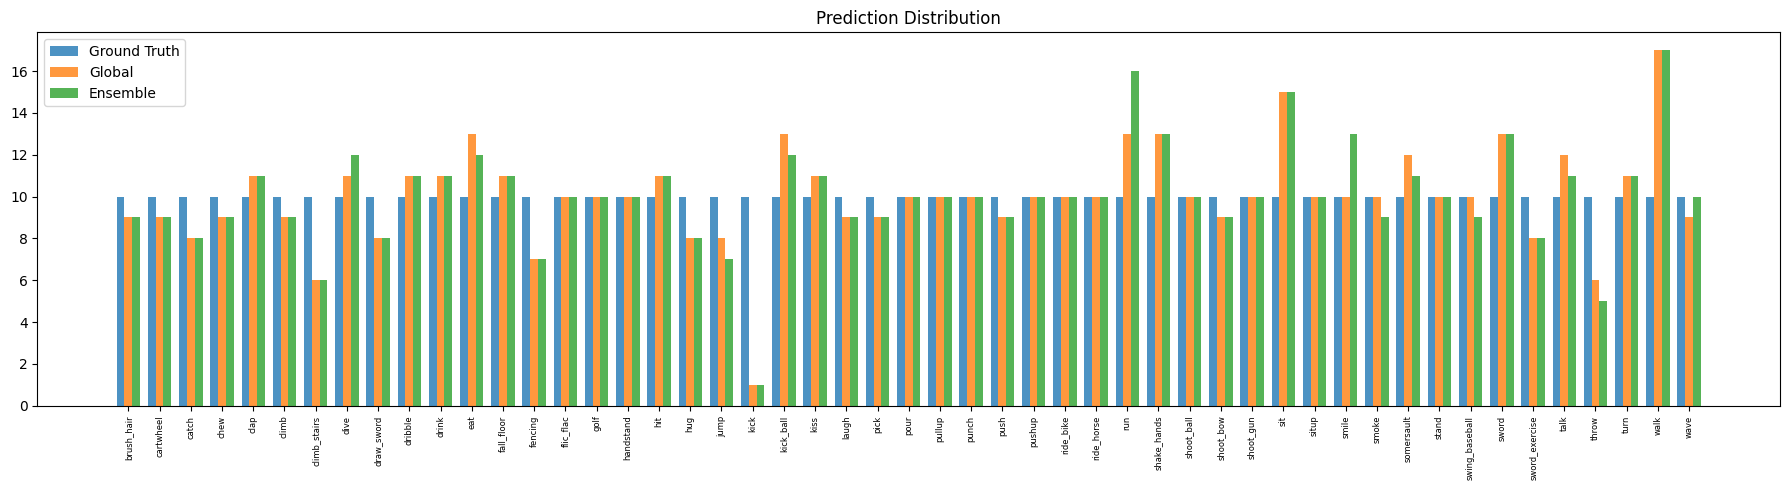

In [50]:
gt_cnt = Counter(all_true)
pg_cnt = Counter(preds_global)
pe_cnt = Counter(preds_ensemble)

cls_sorted = sorted(MAIN_CLASSES, key=lambda x: gt_cnt.get(x,0), reverse=True)
x = np.arange(len(cls_sorted))
w = 0.25

fig, ax = plt.subplots(figsize=(18, 5))
ax.bar(x-w, [gt_cnt.get(c,0) for c in cls_sorted], w, label='Ground Truth', alpha=0.8)
ax.bar(x, [pg_cnt.get(c,0) for c in cls_sorted], w, label='Global', alpha=0.8)
ax.bar(x+w, [pe_cnt.get(c,0) for c in cls_sorted], w, label='Ensemble', alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(cls_sorted, rotation=90, fontsize=6)
ax.legend(); ax.set_title('Prediction Distribution')
plt.tight_layout(); plt.savefig('pred_distribution_improved.png', dpi=150); plt.show()

## 18. Final Summary

In [51]:
print('='*60)
print('FINAL SUMMARY - IMPROVED VERSION')
print('='*60)
print(f'\n📌 IMPROVEMENTS APPLIED:')
print(f'  1. TTA Multi-view Testing: {USE_TTA} (6 views/video)')
print(f'  2. Class-Balanced Sampling: WeightedRandomSampler (no undersampling)')
print(f'  3. Adaptive Ensemble: Confidence threshold = {CONFIDENCE_THRESHOLD}')
print(f'\n📌 CONFIGURATION:')
print(f'  Specialist A: {SPECIALIST_A_TARGETS}')
print(f'  Specialist B: {SPECIALIST_B_TARGETS}')
print(f'  Sensitive Classes: {SENSITIVE_CLASSES}')
print(f'  Fusion Weight: {FUSION_WEIGHT}')
print(f'\n📌 RESULTS:')
print(f'  Global Accuracy:   {acc_g*100:.2f}%')
print(f'  Ensemble Accuracy: {acc_e*100:.2f}%')
print(f'  Improvement:       {(acc_e-acc_g)*100:+.2f}%')
print(f'  Specialist Usage:  {100*total_specialist_used/len(all_true):.1f}% of samples')
print('='*60)

FINAL SUMMARY - IMPROVED VERSION

📌 IMPROVEMENTS APPLIED:
  1. TTA Multi-view Testing: True (6 views/video)
  2. Class-Balanced Sampling: WeightedRandomSampler (no undersampling)
  3. Adaptive Ensemble: Confidence threshold = 0.7

📌 CONFIGURATION:
  Specialist A: ['jump', 'run', 'climb_stairs']
  Specialist B: ['smile', 'talk', 'laugh']
  Sensitive Classes: ['jump', 'run', 'climb_stairs', 'smile', 'talk', 'laugh']
  Fusion Weight: 1.0

📌 RESULTS:
  Global Accuracy:   82.35%
  Ensemble Accuracy: 82.35%
  Improvement:       +0.00%
  Specialist Usage:  45.1% of samples
